In [1]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys
from collections import Counter

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
stimuli_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/analysis_helpers.pyc'>

### setup

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions_recog']

# which iteration name should we use?
iterationName = 'pilot3'

### get basic participation stats

In [5]:
## list of researchers
researchers = ['A4SSYO0HDVD4E', 'A1BOIDKD33QSDK','A1MMCS8S8CTWKU']
num_correct_thresh = 0
num_catch_correct_thresh = 4

## get list of valid sessions with reasonable accuracy
workers = coll.find({ '$and': [{'iterationName':iterationName}]}).distinct('workerId')
workers = [i for i in workers if len(i)>10 and i not in researchers] ## filter workers
print '{} workers performed this task'.format(len(workers))

261 workers performed this task


In [6]:
## get total number of recog events in the collection as a whole
top_workers = []
catch_passable = []
for i,w in enumerate(workers):
    print 'Analyzing {} | {} of {}'.format(w,str(i).zfill(3),len(workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
    if R.count()==45:
        num_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False},{'correct':1}]}).sort('time',-1).count()
        num_catch_trial_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True},{'correct':1}]}).sort('time',-1).count()    
        num_catch_trials_shown = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True}]}).sort('time',-1).count()
        catch_passable.append(num_catch_trial_correct)
        ## make sure: (1) num correct was higher than thresh, (2) all 5 catch trials showed, 
        ## (3) catch trials were correct above threshold, and (4) it was a full session 
        if (num_correct >= num_correct_thresh) & (num_catch_trials_shown==5) & \
            (num_catch_trial_correct >= num_catch_correct_thresh): 
                top_workers.append(w)
        
print '{} workers got at least {} experimental trials correct and {} catch trials correct and finished the entire HIT.'.format(len(top_workers),num_correct_thresh, num_catch_correct_thresh)        
print '{} workers out of {} got fewer than the threshold correct.'.format(np.sum(np.array(catch_passable)<num_catch_correct_thresh), len(catch_passable))

223 workers got at least 0 experimental trials correct and 4 catch trials correct and finished the entire HIT.
22 workers out of 245 got fewer than the threshold correct.


In [7]:
# ## check how much to bonus a particular worker via compensation HIT
# reallyRun = False
# if reallyRun:
#     w = ''
#     C = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
#     for c in C:
#         print c['score'], c['numCorrectSoFar']
#         clear_output(wait=True)

### construct group dataframe

In [8]:
## get total number of recog events in the collection as a whole
# grab rep & accuracy
rep = []
correct = []
rt = []
condition = []
orig_correct = []
generalization = []
target = []
distractor1 = []
distractor2 = []
distractor3 = []
orig_gameID = []
gameID = []
version = [] ## yoked vs. scrambled40 vs. scrambled 10
recog_id = []
for i,w in enumerate(top_workers):
    print 'Now analyzing {} | {} of {}'.format(w,str(i+1).zfill(3), len(top_workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False}]}).sort('time')
    for r in R:        
        rep.append(r['repetition'])
        correct.append(r['correct'])
        rt.append(r['rt'])
        condition.append(r['condition'])
        if 'outcome' in r.keys():
            orig_correct.append(r['outcome'])
        else:
            orig_correct.append(r['original_correct'])
        generalization.append(r['Generalization'])
        target.append(r['target'])
        distractor1.append(r['distractor1'])
        distractor2.append(r['distractor2'])
        distractor3.append(r['distractor3'])
        orig_gameID.append(r['sketch'].split('_')[0])
        gameID.append(r['gameID'])
        version.append(r['version'])
        recog_id.append(r['recog_id'])
    
### make dataframe
X = pd.DataFrame([rep,correct,rt,condition,orig_correct,\
                 generalization,target,distractor1,distractor2,\
                 distractor3,orig_gameID,gameID,version,recog_id])
X = X.transpose()
X.columns = ['repetition','correct','rt','condition', 'orig_correct',\
             'generalization','target','distractor1','distractor2',\
             'distractor3','orig_gameID','gameID','version','recog_id']

## convert datatypes to numeric
X['correct'] = pd.to_numeric(X['correct'])
X['rt'] = pd.to_numeric(X['rt'])
X['orig_correct'] = pd.to_numeric(X['orig_correct'])
    
print 'Finished analyzing top workers.'
print 'There are {} observation in the dataframe.'.format(X.shape[0])

Finished analyzing top workers.
There are 8920 observation in the dataframe.


#### preprocessing helper 

In [9]:
## function to unroll target, distractor dicts into separate columns
def dict2cols(X,item='target'):
    '''
    X = dataframe containing group data
    item = which item column to unroll: target? distractor1? 
    '''
    df = pd.DataFrame.from_dict(X[item]) ## make temporary dataframe with dictionary as main column
    df2 = df[item].apply(pd.Series) ## separate into different columns
    ## rename to ensure uniqueness
    df3 = df2.rename(columns={'objectname': '{}_objectname'.format(item),\
                              'shapenetid': '{}_shapenetid'.format(item),\
                              'url': '{}_url'.format(item)})
    X2 = X.join(df3) ## add to original group dataframe
    X2.drop(labels=[item],axis=1,inplace=True) ## remove old dictionary column
    return X2

## now actually apply unrolling function
items = ['target','distractor1','distractor2','distractor3']
for item in items: 
    print 'Unrolling {}'.format(item)
    clear_output(wait=True)
    if item in X.columns:
        X = dict2cols(X,item=item)
        
print 'Finished unrolling item dictionaries into separate columns.'

Finished unrolling item dictionaries into separate columns.


In [10]:
## view recognizability by repetition in tabular form
X.groupby(['condition','repetition'])['correct'].mean()

condition  repetition
control    0             0.625561
           1             0.660314
repeated   0             0.654709
           1             0.697309
           2             0.733184
           3             0.701794
           4             0.752242
           5             0.741031
           6             0.762332
           7             0.758969
Name: correct, dtype: float64

In [11]:
## how many games from each version were finished?
X.groupby('version')['repetition'].count()/40

version
scrambled40    117.0
yoked          106.0
Name: repetition, dtype: float64

### check representation of original game data in yoked/scrambled40 experiments

In [12]:
## subset by yoked experiment 
Y = X[X['version']=='yoked']

## which orig_gameIDs got played in yoked?
orig_gameIDs_yoked = Counter(Y['orig_gameID']).keys()

## how many orig_gameIDs got played in yoked?
num_unique_orig_games = len(Counter(Y['orig_gameID']).keys())
print '{} original gameIDs appeared in the yoked experiment.'.format(num_unique_orig_games)

## how many times did each of the orig_gameIDs that did appear in yoked experiment get played?
orig_gameIDs_reps = Counter([int(i/40) for i in Counter(Y['orig_gameID']).values()])
for entry in orig_gameIDs_reps.keys():
    print '   {} were played {} times in the yoked experiment.'.format(orig_gameIDs_reps[entry],entry)

## which original gameIDs not yet represented in the yoked dataset?
## load in original group_data
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)
orig_gameID_list = list(np.unique(O['gameID']))
orig_gameIDs_not_yet_yoked = [i for i in orig_gameID_list if i not in orig_gameIDs_yoked]
print 'There are {} original gameIDs that have not yet been played in the yoked experiment.'.format(len(orig_gameIDs_not_yet_yoked))

## save out list of gameIDs remaining in the stimuli folder, to allow these to be uploaded as their own dataset
## for targeted recruitment
if len(orig_gameIDs_not_yet_yoked)>=1:
    U = pd.DataFrame(orig_gameIDs_not_yet_yoked)
    U.columns = ['gameID']
    U.to_csv(os.path.join(stimuli_dir,'orig_gameIDs_remaining_yoked.csv'),index=False)
    print 'Saving out this list of gameIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'
else:
    print 'All original gameIDs have appeared in the yoked experiment.'

67 original gameIDs appeared in the yoked experiment.
   37 were played 1 times in the yoked experiment.
   23 were played 2 times in the yoked experiment.
   5 were played 3 times in the yoked experiment.
   2 were played 4 times in the yoked experiment.
There are 0 original gameIDs that have not yet been played in the yoked experiment.
All original gameIDs have appeared in the yoked experiment.


In [13]:
## subset by scrambled40
S = X[X['version']=='scrambled40']

## how many recog_ids got played in yoked?
num_unique_orig_recogids = len(Counter(S['recog_id']).keys())
print '{} recog_ids appeared in the scrambled40 experiment.'.format(num_unique_orig_recogids)

## which recog_ids got played in scrambled40?
recog_ids_scrambled = Counter(S['recog_id']).keys()

recog_id_reps = Counter([int(i) for i in Counter(S['recog_id']).values()])
for entry in sorted(recog_id_reps.keys()):
    print '   {} games appeared {} trials from them appear in the scrambled40 experiment.'.format(recog_id_reps[entry],entry)

## which recog_ids remaining?
recog_id_list = list(np.unique(O['recog_id']))
recog_ids_remaining = [i for i in recog_id_list if i not in recog_ids_scrambled]
grouped_recog_ids_remaining = np.unique([np.int64(i/4) for i in recog_ids_remaining])
print 'There are still {} grouped_recog_ids to run.'.format(len(grouped_recog_ids_remaining))

if len(grouped_recog_ids_remaining)>=1:
    U = pd.DataFrame(grouped_recog_ids_remaining)
    U.columns = ['grouped_recog_id']
    U.to_csv(os.path.join(stimuli_dir,'grouped_recog_ids_remaining_scrambled40.csv'),index=False)
    print 'Saving out this list of recogIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'
else:
    print 'All original grouped_recog_ids have appeared in the scrambled40 experiment.'    

268 recog_ids appeared in the scrambled40 experiment.
   124 games appeared 10 trials from them appear in the scrambled40 experiment.
   96 games appeared 20 trials from them appear in the scrambled40 experiment.
   40 games appeared 30 trials from them appear in the scrambled40 experiment.
   8 games appeared 40 trials from them appear in the scrambled40 experiment.
There are still 0 grouped_recog_ids to run.
All original grouped_recog_ids have appeared in the scrambled40 experiment.


### visualize recognizability x repetition

/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


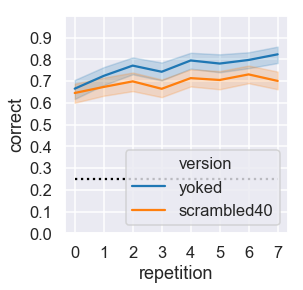

In [14]:
## get dataframe subsetted by condition and broken out by target
X2 = X[X['condition']=='repeated'].reset_index(drop=True)
X2 = X2.sort_values(by=['target_objectname'])
targ_list = np.unique(X2.target_objectname.values)
sns.set_context('talk')

## plot recognizability, collapsing across target
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=X2,x='repetition',y='correct',hue='version')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')

# ## plot recognizability, split out by target
# fig = plt.figure(figsize=(16,16))
# g = sns.FacetGrid(X2, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
# g.map(sns.lineplot, "repetition", "correct", alpha=.7)
# g.set_titles("{col_name}")
# plt.tight_layout()

### aggregate with original refgame dataset and compare

In [15]:
## load in original group_data
path_to_group_data = os.path.join(results_dir,'graphical_conventions.csv')
O = pd.read_csv(path_to_group_data)

In [16]:
## aggregate original refgame and recog dataframes
## and add some handy additional fields
OR = O[O['condition']=='repeated'].reset_index(drop=True)
OR = OR.rename(columns={'outcome':'correct'})
OR['logRT'] = np.log(OR['drawDuration']*1000)
OR['version'] = pd.Series(['refgame']*len(OR))
X2['logRT'] = np.log(X2['rt']) ## add log RT

In [17]:
## save out concatenated dataframe for stats
_OR = OR[['version','repetition','gameID','condition','target', 'correct', 'logRT']]
_X2 = X2[['version','repetition','gameID','condition','target_objectname','correct', 'logRT']]
_X2.rename({'target_objectname':'target'}, axis='columns',inplace=True)
## concatenated original and recog experiments
R = pd.concat([_OR,_X2],axis=0,sort=False).reset_index()
R.to_csv(os.path.join(results_dir,'graphical_conventions_recog_data.csv'),index=False)

/Users/judithfan/Library/Python/2.7/lib/python/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


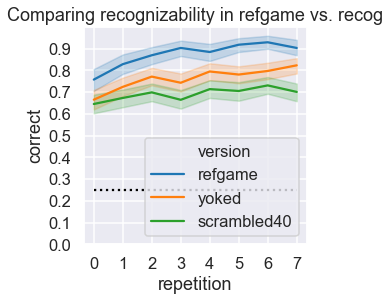

In [18]:
## plot accuracy timecourse
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=R,x='repetition',y='correct',hue='version')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing recognizability in refgame vs. recog')

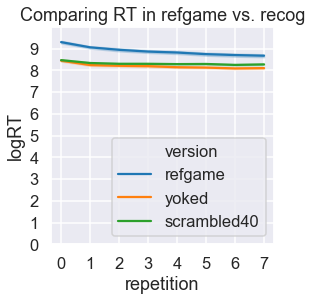

In [19]:
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=R,x='repetition',y='logRT',hue='version')
plt.ylim(0,10)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 8, 1))
# plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing RT in refgame vs. recog')

### compute BIS (z-score within new gameID)

In [20]:
def zscore(x,mu,sd):
    return (x-mu)/(sd+1e-6)

In [21]:
## sort dataframe by gameID, repetition, and target_objectname
X3 = R.sort_values(by=['gameID','repetition','target']).reset_index(drop=True)

# ##subset by yoked experiment data only
# X3 = X3[X3['version']=='yoked']

In [22]:
## groupby gameID
grouped = X3.groupby('gameID')

## init new aggregated vars
acc_norm = []
rt_norm = []
bis = []
gameID = []
repetition = []
version = []
rep1_acc = []
rep1_rt = []
rep1_bis = []

## loop through games
for name, group in grouped:
    print 'Analyzing {}'.format(name)
    clear_output(wait=True)
    rt_mu = group['logRT'].mean()
    rt_sd = group['logRT'].std()    
    acc_mu = group['correct'].mean()
    acc_sd = group['correct'].std()
    repwise = group.groupby('repetition')
    ## loop through reps within games
    for name,rep in repwise:
        rep_acc_raw = rep['correct'].mean()
        rep_rt_raw = rep['logRT'].mean()             
        accN = zscore(rep_acc_raw,acc_mu,acc_sd)
        rtN = zscore(rep_rt_raw,rt_mu,rt_sd)
        if np.unique(rep['repetition'])[0]==0:
            _rep1_acc = accN
            _rep1_rt = rtN 
            _rep1_bis = accN-rtN
        rep1_acc.append(_rep1_acc)
        rep1_rt.append(_rep1_rt)
        rep1_bis.append(_rep1_bis)
        acc_norm.append(accN)
        rt_norm.append(rtN)        
        bis.append(accN-rtN)
        assert len(np.unique(rep['gameID'].values))==1
        gameID.append(np.unique(rep['gameID'].values)[0])
        repetition.append(np.unique(rep['repetition'].values)[0])
        version.append(np.unique(group['version'])[0])

Analyzing 9988-c81681b3-028f-45ce-8b70-927d50e87268


In [23]:
## construct summary dataframe (aggregates within repetition)
X4 = pd.DataFrame([gameID,repetition,acc_norm,rt_norm,bis,rep1_bis,version])
X4 = X4.transpose()
X4.columns = ['gameID','repetition','acc_norm','rt_norm','bis','rep1_bis','version']

## convert to numeric datatype
X4['bis']=pd.to_numeric(pd.Series(X4['bis']))
X4['rep1_bis']=pd.to_numeric(pd.Series(X4['rep1_bis']))
X4['acc_norm']=pd.to_numeric(pd.Series(X4['acc_norm']))
X4['rt_norm']=pd.to_numeric(pd.Series(X4['rt_norm']))

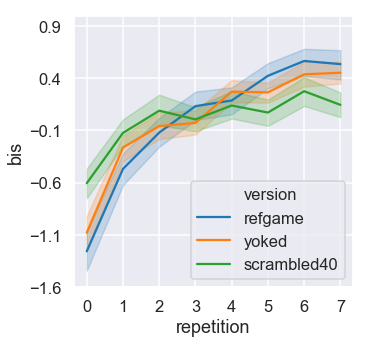

In [24]:
## visualize BIS x repetition
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition',y='bis',hue='version')
plt.ylim(-1.5,1)
t = plt.yticks(np.arange(-1.6, 1.1, 0.5))
t = plt.xticks(np.arange(0, 8, 1))

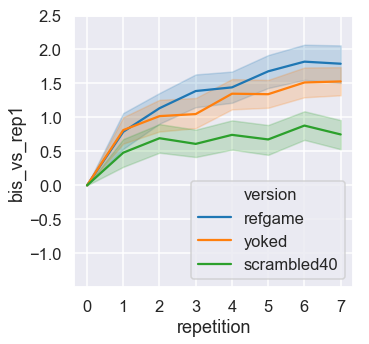

In [25]:
## baseline bis against first rep
X4['bis_vs_rep1'] = X4['bis']-X4['rep1_bis']
## save it out 
X4.to_csv(os.path.join(results_dir,'graphical_conventions_recog_data_bis.csv'),index=False)
## plot it
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition',y='bis_vs_rep1',hue='version')
plt.ylim(-1.5,1)
t = plt.yticks(np.arange(-1., 3, 0.5))
t = plt.xticks(np.arange(0, 8, 1))
plt.legend(loc = 'lower right')